## Figs

In [ ]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["CUDA_VISIBLE_DEVICES"] = "0" 

import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
# import tensorflow as tf
from tensorflow.keras.models import load_model
from skimage import metrics

In [ ]:
path = os.path.abspath("..")

X_val = np.load(path+"/train_test_data/X_val.npy")
y_val = np.load (path+"/train_test_data/y_val.npy")

## New validation model data from new simulation to validate the model
# X_val = np.load(path+"/quantification/validation_dataset/X.npy")
# y_val = np.load (path+"/quantification/validation_dataset/y.npy")

X_val.shape, y_val.shape

In [ ]:
model = load_model(path+"/lstm_model_2.h5")
history = np.load(path+"/history_2.npy", allow_pickle=True).item()

model.summary()

In [ ]:
## Scaling the array values from 0 to 255 for 0 as black pixel and 255 as white pixel for calculation of structural similarity
## Scaling is done to both Ground Truth and Predicted Frame
def scale_array(arr):
    arr_min = np.min(arr)  ## Flattens the array and finds the min value inside it
    arr_max = np.max(arr)  ## Flattens the array and finds the max value inside it
    scaled_array = (arr - arr_min) / (arr_max - arr_min) * 255
    scaled_array = scaled_array.astype(np.uint8)
    
    return scaled_array

In [ ]:
GT_array = y_val
a, b, c, d, e = y_val.shape[0], y_val.shape[1], y_val.shape[2], y_val.shape[3], y_val.shape[4] 
PD_array = np.zeros((a, b, c, d, e))   ## Predicted arrays

for i in range(X_val.shape[0]):
  frames = X_val[i]   ## taking 1 validation video sample at one time
  PD_array[i] = model.predict(np.expand_dims(frames, axis=0), verbose=0, workers=10, use_multiprocessing=True)

GT_array.shape, PD_array.shape

In [ ]:
## Scaling the array values from 0 to 255 for 0 as black pixel and 255 as white pixel for calculation of structural similarity
## Scaling is done to both Ground Truth and Predicted Frame

GT_scaled = scale_array(GT_array)
PD_scaled = scale_array(PD_array)

In [ ]:
GT_scaled.shape

In [ ]:
GT_scaled[2,14,:,:,0].shape

In [ ]:
plt.imshow(GT_scaled[3,13,:,:,0])

In [ ]:
from sklearn.model_selection import train_test_split
from skimage import metrics

In [ ]:
GT_sam, _, PD_sam, _ = train_test_split(GT_array, PD_array, test_size=0.92, random_state=61)  ## Randomly sampling 10 video sequence for further anaylisis from Generation 0
GT_sam.shape, PD_sam.shape

In [ ]:
vs = 3

fig = plt.figure(figsize=(16, 8)) # adjust figure size as needed
ax1 = fig.add_subplot(2, 4, 1)
ax2 = fig.add_subplot(2, 4, 2)
ax3 = fig.add_subplot(2, 4, 3)
ax4 = fig.add_subplot(2, 4, 4)
ax5 = fig.add_subplot(2, 4, 5)
ax6 = fig.add_subplot(2, 4, 6)
ax7 = fig.add_subplot(2, 4, 7)
ax8 = fig.add_subplot(2, 4, 8)

ax1.imshow(GT_sam[vs,0,:,:,0], 'gray')
ax2.imshow(GT_sam[vs,3,:,:,0], 'gray')
ax3.imshow(GT_sam[vs,6,:,:,0], 'gray')
ax4.imshow(GT_sam[vs,8,:,:,0], 'gray')
ax5.imshow(PD_sam[vs,10,:,:,0], 'gray')
ax6.imshow(PD_sam[vs,12,:,:,0], 'gray')
ax7.imshow(PD_sam[vs,14,:,:,0], 'gray')
ax8.imshow(PD_sam[vs,-1,:,:,0], 'gray')

ax1.axis("off")
ax2.axis("off")
ax3.axis("off")
ax4.axis("off")
ax5.axis("off")
ax6.axis("off")
ax7.axis("off")
ax8.axis("off")


plt.show()

In [ ]:
# vs = 0 # Video frame to look for visualtization
for vs in range(GT_sam.shape[0]):
  fig, axes = plt.subplots(2, 17, figsize=(28, 4))
  fig.suptitle(f"Generation 1 Prediction of Video Sequence No: {vs}" , fontsize=20)
  for idx, ax in enumerate(axes[0]):
      ax.imshow(np.squeeze(GT_sam[vs:vs+1, idx:idx+1,:,:,:]), cmap="gray")
      ax.set_title(f"GT Frame {idx + 4}", size=10)
      ax.axis("off")
  
  for idx, ax in enumerate(axes[1]):
      ax.imshow(np.squeeze(PD_sam[vs:vs+1, idx:idx+1,:,:,:]), cmap="gray")
      ax.set_title(f"Pred Frame {idx + 4}", size=8)
      ax.axis("off")
  plt.show()

In [ ]:
vs = 1
f = 12

pd_img = scale_array(PD_array[vs,10,:,:,0])
gt_img = scale_array(GT_array[vs,f,:,:,0])

pd_arr = scale_array(PD_array[:,:,:,:,0])
gt_arr = scale_array(GT_array[:,:,:,:,0])

from skimage.exposure import histogram

hist1, hist_centers1 = histogram(gt_arr)
hist2, hist_centers2 = histogram(pd_arr)

fig = plt.figure(figsize=(8, 8)) # adjust figure size as needed
# create subplots

ax1 = fig.add_subplot(2, 1, 1) # column 1 and 2, row 1
ax2 = fig.add_subplot(2, 2, 3) # column 1, row 2
ax3 = fig.add_subplot(2, 2, 4) # column 2, row 2

ax1.plot(hist_centers1, hist1, lw=2, color='red', label='GT')
ax1.plot(hist_centers2, hist2, lw=2, color="blue", label='PD')
ax1.set_title('histogram of gray values', size = 20)
ax1.set_ylabel("No. of Pixels", size= 20)
ax1.set_xlabel("Pixel's Intensity Value (0 to 255)", size= 20)
ax1.legend(loc=0, fontsize=12)

ax2.imshow(gt_img, cmap='gray')

x1 = 0.78
y1 = 0.2

x2 = 0.78
y2 = 0.88

height, width = gt_img.shape[:2] 
pixel_x1 = int(x1 * width)
pixel_y1 = int(y1 * height)
pixel_x2 = int(x2 * width)
pixel_y2 = int(y2 * height)

pixel_value1 = gt_img[pixel_y1, pixel_x1]
pixel_value2 = gt_img[pixel_y2, pixel_x2]

radius = 2
center1 = (pixel_x1, pixel_y1)
center2 = (pixel_x2, pixel_y2)

circle1 = Circle(center1, radius, linestyle='-', linewidth=5, edgecolor='red', facecolor='none')
circle2 = Circle(center2, radius, linestyle='-', linewidth=5, edgecolor='red', facecolor='none')

ax2.add_patch(circle1)
ax2.add_patch(circle2)


angle1 = np.arctan2(pixel_y1 - center1[1], pixel_x1 - center1[0])
angle2 = np.arctan2(pixel_y2 - center2[1], pixel_x2 - center2[0])

start_x1 = center1[0] + radius * np.cos(angle1)
start_y1 = center1[1] + radius * np.sin(angle1)
start_x2 = center2[0] + radius * np.cos(angle2)
start_y2 = center2[1] + radius * np.sin(angle2)

# ax.plot(pixel_x, pixel_y, 'o', markersize=5)
ax2.annotate(f'$P_I$: {pixel_value1}', (pixel_x1+1, pixel_y1),
             xytext=(100, 0), textcoords='offset points', fontsize=20, weight = 'bold', color = 'black',
             arrowprops=dict(arrowstyle="-|>", linewidth=7, connectionstyle="arc3,rad=0", color='m',)
           )

ax2.annotate(f'$P_I$ : {pixel_value2}', (pixel_x2+1, pixel_y2),
             xytext=(100, 0), textcoords='offset points', fontsize=20, weight = 'bold',
             arrowprops=dict(arrowstyle="-|>", linewidth=7, connectionstyle="arc3,rad=-0", color='yellow',)
           )

ax3.imshow(pd_img, cmap='gray')

x1 = 0.1
y1 = 0.2

x2 = 0.78
y2 = 0.88

height, width = pd_img.shape[:2] 
pixel_x1 = int(x1 * width)
pixel_y1 = int(y1 * height)
pixel_x2 = int(x2 * width)
pixel_y2 = int(y2 * height)

pixel_value1 = pd_img[pixel_y1, pixel_x1]
pixel_value2 = pd_img[pixel_y2, pixel_x2]

radius = 2
center1 = (pixel_x1, pixel_y1)
center2 = (pixel_x2, pixel_y2)

circle1 = Circle(center1, radius, linestyle='-', linewidth=5, edgecolor='red', facecolor='none')
circle2 = Circle(center2, radius, linestyle='-', linewidth=5, edgecolor='red', facecolor='none')

ax3.add_patch(circle1)
ax3.add_patch(circle2)


angle1 = np.arctan2(pixel_y1 - center1[1], pixel_x1 - center1[0])
angle2 = np.arctan2(pixel_y2 - center2[1], pixel_x2 - center2[0])

start_x1 = center1[0] + radius * np.cos(angle1)
start_y1 = center1[1] + radius * np.sin(angle1)
start_x2 = center2[0] + radius * np.cos(angle2)
start_y2 = center2[1] + radius * np.sin(angle2)

# ax.plot(pixel_x, pixel_y, 'o', markersize=5)
ax3.annotate(f'$P_I$: {pixel_value1}', (pixel_x1-1, pixel_y1),
             xytext=(-150, -5), textcoords='offset points', fontsize=20, weight = 'bold', color = 'black',
             arrowprops=dict(arrowstyle="-|>", linewidth=7, connectionstyle="arc3,rad=0", color='m',)
           )

ax3.annotate(f'$P_I$ : {pixel_value2}', (pixel_x2+1, pixel_y2),
             xytext=(100, -5), textcoords='offset points', fontsize=20, weight = 'bold',
             arrowprops=dict(arrowstyle="-|>", linewidth=7, connectionstyle="arc3,rad=-0", color='yellow',)
           )

plt.subplots_adjust(hspace=0.5)
# display the plot

plt.show()

In [ ]:
ax3.imshow(pd_img, cmap='gray')

x1 = 0.78
y1 = 0.2

x2 = 0.78
y2 = 0.88

height, width = pd_img.shape[:2] 
pixel_x1 = int(x1 * width)
pixel_y1 = int(y1 * height)
pixel_x2 = int(x2 * width)
pixel_y2 = int(y2 * height)

pixel_value1 = pd_img[pixel_y1, pixel_x1]
pixel_value2 = pd_img[pixel_y2, pixel_x2]

radius = 2
center1 = (pixel_x1, pixel_y1)
center2 = (pixel_x2, pixel_y2)

circle1 = Circle(center1, radius, linestyle='-', linewidth=5, edgecolor='red', facecolor='none')
circle2 = Circle(center2, radius, linestyle='-', linewidth=5, edgecolor='red', facecolor='none')

ax3.add_patch(circle1)
ax3.add_patch(circle2)


angle1 = np.arctan2(pixel_y1 - center1[1], pixel_x1 - center1[0])
angle2 = np.arctan2(pixel_y2 - center2[1], pixel_x2 - center2[0])

start_x1 = center1[0] + radius * np.cos(angle1)
start_y1 = center1[1] + radius * np.sin(angle1)
start_x2 = center2[0] + radius * np.cos(angle2)
start_y2 = center2[1] + radius * np.sin(angle2)

# ax.plot(pixel_x, pixel_y, 'o', markersize=5)
ax3.annotate(f'$P_I$: {pixel_value1}', (pixel_x1+1, pixel_y1),
             xytext=(100, 0), textcoords='offset points', fontsize=20, weight = 'bold', color = 'black',
             arrowprops=dict(arrowstyle="-|>", linewidth=7, connectionstyle="arc3,rad=0", color='m',)
           )

ax3.annotate(f'$P_I$ : {pixel_value2}', (pixel_x2+1, pixel_y2),
             xytext=(100, 0), textcoords='offset points', fontsize=20, weight = 'bold',
             arrowprops=dict(arrowstyle="-|>", linewidth=7, connectionstyle="arc3,rad=-0", color='yellow',)
           )


ax3.set_xlabel('X')
ax3.set_ylabel('Y')

## Test

In [236]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
from math import pi

In [2]:
# gen = [0, 1, 2, 3]
ssim_g0_vs = [0.98526247, 0.98493955, 0.98899886, 0.98633312, 0.98633312,0.98467691, 0.98334682, 0.98512739, 0.98505301, 0.99368928,0.99209458, 0.98111205, 0.98208058, 0.98522574, 0.99252631,0.92355011, 0.96329952, 0.99412594, 0.98571577, 0.98814328,0.98913366, 0.98899886, 0.94585554, 0.97791251, 0.93868516,0.99386033, 0.99137922, 0.97846206, 0.99360098, 0.94686679,0.99316891, 0.98467691, 0.98150434, 0.97725906, 0.98015521,0.98081445, 0.98838155, 0.98726753, 0.99329082, 0.99405919,0.98505301, 0.99019278, 0.99395174, 0.98473439, 0.98518686,0.98979205, 0.98820468, 0.99199811, 0.98640705, 0.98615858,0.99385436, 0.99455265, 0.98971295, 0.99161009, 0.99279528,0.98627383, 0.99226449, 0.98570092, 0.99365695, 0.99435189,0.97619332, 0.99386947, 0.99048139, 0.99438626, 0.99441175,0.9887901 , 0.97134186, 0.98719601, 0.98832925, 0.9930205 ,0.93546078, 0.98625495, 0.99447356, 0.98072066, 0.99303679,0.9939263 , 0.99353463, 0.98247692, 0.99420837, 0.98625927,0.97998168, 0.98715859, 0.99046595, 0.98899886, 0.97791251,0.93021587, 0.98060808, 0.98555406, 0.98568868, 0.99274639,0.99367551, 0.99458388, 0.98517926, 0.98032847, 0.98163839,0.96329952, 0.96581667, 0.99262721, 0.98384199, 0.98582978,0.98449749, 0.99161009, 0.91447848, 0.98904803, 0.98912077,0.98060808, 0.99245606, 0.98506341, 0.99181538, 0.99377726,0.98700399, 0.98466017, 0.99291071, 0.99198549, 0.98522574,0.99119797, 0.99437912, 0.97959584, 0.98463849, 0.93021587,0.98899886, 0.99303057, 0.99389336, 0.99373874, 0.99390927,0.9117635 , 0.98628936, 0.990905  , 0.98531587, 0.98509031,0.93546078, 0.99369546, 0.99219414, 0.98599431, 0.99337338, 0.99155449, 0.99456203,   0.98526247,]
ssim_g1_vs = [0.96716059, 0.9665157 , 0.9716713 , 0.96805888, 0.96805888, 0.96700788, 0.96440059, 0.96962138, 0.9667236 , 0.98471201, 0.98139291, 0.96051586, 0.9539543 , 0.97154257, 0.981545  , 0.89235618, 0.94272078, 0.98554381, 0.96808208, 0.973436  , 0.97649994, 0.9716713 , 0.91927181, 0.96123006, 0.9096223 , 0.98617191, 0.97934423, 0.94503463, 0.98436076, 0.92054136, 0.98390693, 0.96700788, 0.96672907, 0.96016352, 0.95873127, 0.95990851, 0.97020225, 0.97062928, 0.98373496, 0.98534553, 0.9667236 , 0.97820302, 0.9855576 , 0.96746285, 0.96557218, 0.97705052, 0.97244913, 0.98185729, 0.96849666, 0.96775483, 0.98614588, 0.98658191, 0.97731232, 0.98109519, 0.98341413, 0.97039399, 0.98299825, 0.96676505, 0.98497134, 0.98627551, 0.95869742, 0.9861292 , 0.97970275, 0.98669184, 0.98616971, 0.97379973, 0.9276841 , 0.97028159, 0.97270893, 0.98317869, 0.90602599, 0.96801735, 0.98639347, 0.95923263, 0.98198885, 0.985778  , 0.98503608, 0.96267132, 0.9860349 , 0.96801007, 0.95845959, 0.97186302, 0.97753018, 0.9716713 , 0.96123006, 0.90026253, 0.95943132, 0.97035408, 0.97028969, 0.98217876, 0.9853398 , 0.98667992, 0.96548744, 0.95906969, 0.96183405, 0.94272078, 0.94599629, 0.98111138, 0.96528085, 0.96935067, 0.97111143, 0.98109519, 0.88109325, 0.97559117, 0.97661859, 0.95943132, 0.98185028, 0.96531546, 0.98042034, 0.9841167 , 0.97198594, 0.96828736, 0.98267902, 0.98097452, 0.97154257, 0.98141919, 0.98656855, 0.95754484, 0.96602154, 0.90026253, 0.9716713 , 0.98419767, 0.98481644, 0.98474988, 0.98585748, 0.87780622, 0.96804344, 0.97787339, 0.9693426 , 0.96788682, 0.90602599, 0.9850499 , 0.98120408, 0.97047526, 0.98429728, 0.98056626, 0.98663937,   0.96716059,]
ssim_g2_vs = [0.94679777, 0.94569182, 0.95158778, 0.94706956, 0.94706956, 0.94706131, 0.94294311, 0.95215059, 0.94594382, 0.97458023, 0.97013942, 0.93795783, 0.92146212, 0.95705401, 0.96913261, 0.866567  , 0.92340356, 0.97559047, 0.94810487, 0.95664586, 0.96223921, 0.95158778, 0.8953687 , 0.944236  , 0.88369352, 0.97813465, 0.96483065, 0.90790202, 0.97288739, 0.89675714, 0.97309087, 0.94706131, 0.95173001, 0.94285466, 0.93539436, 0.93700146, 0.94853601, 0.95126786, 0.97316943, 0.9751907 , 0.94594382, 0.96427899, 0.97620912, 0.94831174, 0.94319011, 0.96229703, 0.95391599, 0.9700881 , 0.94771155, 0.94651279, 0.97804957, 0.97694459, 0.96278456, 0.96986923, 0.97239029, 0.95248657, 0.97285367, 0.94506622, 0.97519892, 0.97644466, 0.94120619, 0.97830168, 0.9680028 , 0.97775167, 0.97620104, 0.95597158, 0.87992894, 0.95052643, 0.95416769, 0.9711212 , 0.8805114 , 0.94702258, 0.97667428, 0.93547868, 0.96799035, 0.97662198, 0.97536931, 0.94055911, 0.97606393, 0.94701517, 0.93487042, 0.95436926, 0.96222879, 0.95158778, 0.944236  , 0.87507892, 0.93630496, 0.95322887, 0.95296326, 0.97028909, 0.97555206, 0.97708862, 0.94292572, 0.93584316, 0.94005526, 0.92340356, 0.92734457, 0.96735878, 0.94425149, 0.95066842, 0.9572531 , 0.96986923, 0.85332543, 0.96022584, 0.96273039, 0.93630496, 0.96887204, 0.94266762, 0.96863373, 0.97203854, 0.95484911, 0.94991036, 0.97129263, 0.96942924, 0.95705401, 0.97076294, 0.9776657 , 0.93338193, 0.94505084, 0.87507892, 0.95158778, 0.97401457, 0.97417546, 0.973754  , 0.97767873, 0.84979442, 0.94696974, 0.96443959, 0.95117691, 0.948464  , 0.8805114 , 0.97539588, 0.96788956, 0.95270241, 0.97370481, 0.96769323, 0.97706292,   0.94679777,]
ssim_g3_vs = [0.92465369, 0.92333113, 0.918425  , 0.92398596, 0.92398596, 0.92501965, 0.92019321, 0.93134724, 0.92349864, 0.95470413, 0.94965828, 0.91476906, 0.87291869, 0.93574863, 0.94584026, 0.84355436, 0.90119571, 0.95595943, 0.92619006, 0.93633448, 0.94271424, 0.918425  , 0.87110553, 0.92192195, 0.85903729, 0.96233472, 0.94519724, 0.85520186, 0.9544469 , 0.87252618, 0.95451278, 0.92501965, 0.93093058, 0.92045915, 0.91226066, 0.91372696, 0.91323068, 0.92899315, 0.95289558, 0.95522862, 0.92349864, 0.94468849, 0.95797066, 0.92659144, 0.91962894, 0.94164444, 0.9318717 , 0.95260552, 0.92461592, 0.92323554, 0.96215792, 0.95852133, 0.94279985, 0.95010025, 0.95483686, 0.93081438, 0.955798  , 0.92164287, 0.95703518, 0.95899226, 0.91899915, 0.96244429, 0.95033864, 0.9605534 , 0.95703671, 0.93418456, 0.82010083, 0.92807861, 0.93208734, 0.9525976 , 0.85648069, 0.92396134, 0.95800709, 0.91192336, 0.94199784, 0.95934329, 0.95787721, 0.91776383, 0.95867399, 0.92399076, 0.91169799, 0.93231494, 0.94272702, 0.918425  , 0.92192195, 0.85189711, 0.91309074, 0.9323182 , 0.93221168, 0.94789341, 0.95879568, 0.95891764, 0.91889384, 0.91268356, 0.91721993, 0.90119571, 0.90547954, 0.94262677, 0.9216704 , 0.9292751 , 0.93679571, 0.95010025, 0.8288926 , 0.93951996, 0.94341702, 0.91309074, 0.9498464 , 0.91848544, 0.94737849, 0.94919659, 0.93343216, 0.92899565, 0.94973776, 0.94850617, 0.93574863, 0.95347317, 0.96011976, 0.90974551, 0.92269003, 0.85189711, 0.918425  , 0.95636615, 0.95344993, 0.95568086, 0.96110098, 0.82540934, 0.92359716, 0.94085601, 0.93008356, 0.92669024, 0.85648069, 0.95716597, 0.94877557, 0.93173184, 0.95512683, 0.94793635, 0.95904521,   0.92465369,]

In [4]:
# gen_0 = np.ones(len(ssim_g0_vs))
# gen_1 = np.ones(len(ssim_g1_vs))

In [265]:
def wrap_around(radii, s,):
    thetas = [i * (330 / len(radii)) for i in range(15, len(radii))]
    xs = [(s * radius * np.sin(np.deg2rad(theta))) for radius, theta in zip(radii, thetas)]
    ys = [(s * radius * np.cos(np.deg2rad(theta))) for radius, theta in zip(radii, thetas)]
    return xs,ys

def labels(radii, s,):
    thetas = [i * (60 / len(radii)) for i in range(-65, len(radii))]
    xs = [(s * radius * np.sin(np.deg2rad(theta))) for radius, theta in zip(radii, thetas)]
    ys = [(s * radius * np.cos(np.deg2rad(theta))) for radius, theta in zip(radii, thetas)]
    return  xs,ys

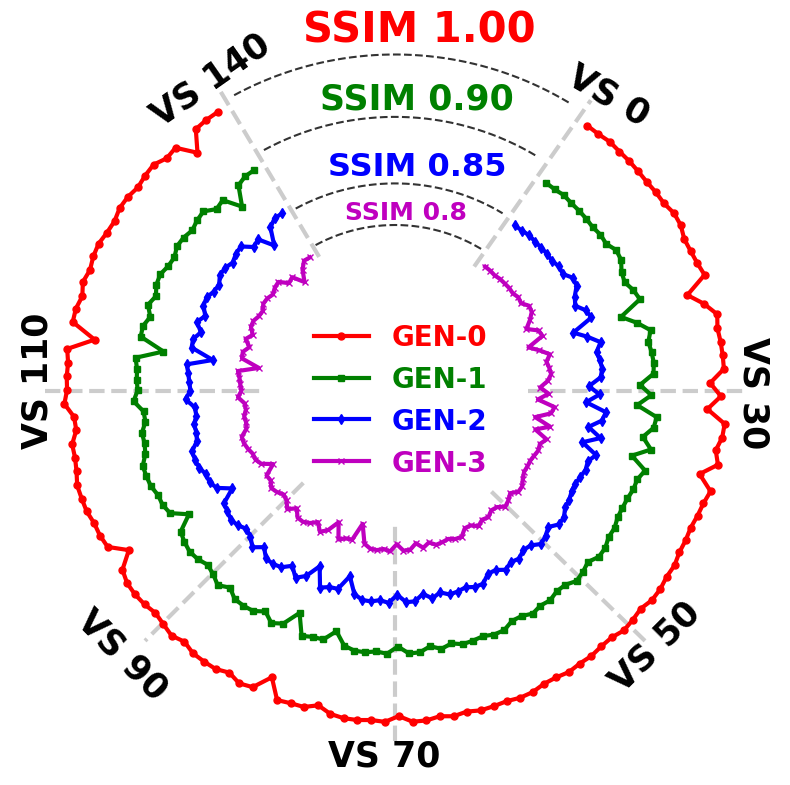

In [408]:
def wrap_around(radii, s,):
    thetas = [i * (330 / len(radii)) for i in range(15, len(radii))]
    xs = [(s * radius * np.sin(np.deg2rad(theta))) for radius, theta in zip(radii, thetas)]
    ys = [(s * radius * np.cos(np.deg2rad(theta))) for radius, theta in zip(radii, thetas)]
    return xs,ys

def labels(radii, s,):
    thetas = [i * (60 / len(radii)) for i in range(-65, len(radii))]
    xs = [(s * radius * np.sin(np.deg2rad(theta))) for radius, theta in zip(radii, thetas)]
    ys = [(s * radius * np.cos(np.deg2rad(theta))) for radius, theta in zip(radii, thetas)]
    return  xs,ys


x0,y0 = wrap_around(ssim_g0_vs, s=20)
x1,y1 = wrap_around(ssim_g1_vs, s=16)
x2,y2 = wrap_around(ssim_g2_vs, s=13)
x3,y3 = wrap_around(ssim_g3_vs, s=10)

a =  np.ones(len(ssim_g0_vs))
l0 = labels(a , 20.25)
l1 = labels(a , 16.5)
l2 = labels(a , 12.5)
l3 = labels(a , 10)
l4 = labels(a , 5)

plt.rcParams["figure.figsize"] = (8,8)

plt.plot([4.75, 11.75], [7.5, 17.5], '--', color = 'black', linewidth=3,  alpha=0.2)
plt.text(10, 16, s="VS 0", color='k',fontsize=25, weight = 'bold', rotation=-30)
plt.hlines(y=0, xmin=8, xmax=21,  color = 'black', linewidth=3, linestyles='dashed', alpha=0.2)
plt.text(20.5, -3, s="VS 30", color='k',fontsize=25, weight = 'bold', rotation=270)
plt.plot([15, 5.5], [-15, -5.75], '--', color = 'black', linewidth=3,  alpha=0.2)
plt.text(12.5, -18, s="VS 50", color='k',fontsize=25, weight = 'bold', rotation=45)
plt.vlines(x=0, ymin=-21, ymax=-8,  color = 'black', linewidth=3, linestyles='dashed', alpha=0.2)
plt.text(-4, -22.5, s="VS 70", color='k',fontsize=25, weight = 'bold', rotation=0)
plt.plot([-5.5, -15], [-5.5, -15], '--', color = 'black', linewidth=3,  alpha=0.2)
plt.text(-19.5, -18.5, s="VS 90", color='k',fontsize=25, weight = 'bold', rotation=-45)
plt.hlines(y=0, xmin=-21, xmax=-8,  color = 'black', linewidth=3, linestyles='dashed', alpha=0.2)
plt.text(-22.5, -3, s="VS 110", color='k',fontsize=25, weight = 'bold', rotation=90)
plt.plot([-10.45, -4.5], [18, 8], '--', color = 'black', linewidth=3,  alpha=0.2)
plt.text(-15, 16, s="VS 140", color='k',fontsize=25, weight = 'bold', rotation=35)


plt.plot(x0, y0, '-o', color='red', label='GEN-0', linewidth=3, markersize=5)
plt.plot(x1, y1, '-s', color='green', label='GEN-1', linewidth=3, markersize=5)
plt.plot(x2, y2, '-d', color='blue', label='GEN-2', linewidth=3, markersize=5)
plt.plot(x3, y3, '-x', color='m', label='GEN-3', linewidth=3, markersize=5)

l0 = plt.plot(l0[0], l0[1], '--', color = 'black', alpha=0.8)
l1 = plt.plot(l1[0], l1[1], '--', color = 'black', alpha=0.8)
l2 = plt.plot(l2[0], l2[1], '--', color = 'black', alpha=0.8)
l3 = plt.plot(l3[0], l3[1], '--', color = 'black', alpha=0.8)
l4 = plt.plot(l4[0], l4[1], '--', color = 'white', alpha=0)

plt.text(-5.5, 21, s="SSIM 1.00", color='red',fontsize=30, weight = 'bold')
plt.text(-4.5, 17, s="SSIM 0.90", color='green',fontsize=25, weight = 'bold')
plt.text(-4, 13, s="SSIM 0.85", color='blue',fontsize=23, weight = 'bold')
plt.text(-3, 10.35, s="SSIM 0.8", color='m',fontsize=18, weight = 'bold')

plt.legend(loc=(0.38,0.38), prop={'weight':'bold', 'size':'20'}, frameon=False, labelcolor='linecolor').get_frame().set_facecolor('none')

plt.axis(False)
plt.tight_layout()
plt.savefig('figures/SSIM_GEN_Circ.png', transparent=True)
# plt.grid()
plt.show()